In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torchvision.datasets import ImageFolder

In [2]:
output_dir = '/home/ec2-user/SageMaker/dataset/cropped/'

In [3]:
def get_file_paths(data_dir: str) -> list:
    """Take a directory as input and return a list of paths to all files inside."""
    file_paths = []
    for root_path, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('png'):
                file_paths.append(os.path.join(root_path, file))
    return file_paths

In [4]:
def load_images(file_paths, dim=(128, 128), verbose=False):
    print(f"Processing {len(file_paths)} image paths...") if verbose else None
    images = []
    
    transform = transforms.Compose([
        transforms.Resize(dim),  # Resize the image
        transforms.ToTensor()  # Convert PIL image to PyTorch tensor
    ])

    for i, file_path in enumerate(file_paths):
        f_path = os.path.join(file_path)
        if "checkpoint" in f_path:
            print(f"[{i+1}] Skipping '{f_path}' (contains 'checkpoint')...") if verbose else None
            continue
        
        # print(f"[{i+1}] Loading '{f_path}' . . .") if verbose else None
        image = Image.open(f_path)
        
        # Convert to RGB if the image has an alpha channel
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        
        image = transform(image)
        images.append(image)
    
    # Resize images to a consistent size
    resized_images = []
    for image in images:
        if image.shape != (3, dim[0], dim[1]):
            resize_transform = transforms.Resize((dim[1], dim[0]))
            image = resize_transform(image)
        resized_images.append(image)
    
    return torch.stack(resized_images)

In [5]:
file_paths = get_file_paths(output_dir)
print(f"Total {len(file_paths)} images in directory.")

Total 4161 images in directory.


In [6]:
# Take a sample of images
percent = 100
N = int(len(file_paths)*percent)
indexes = np.random.randint(low=0, high=len(file_paths), size=N)
sample_files = [path for (i, path) in enumerate(file_paths) if i in indexes]
X = load_images(sample_files, verbose=True, dim=(128, 128))

Processing 4161 image paths...
[4146] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.ipynb_checkpoints/soloAUV 20220919-174051-525_108-checkpoint.png' (contains 'checkpoint')...
[4147] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.ipynb_checkpoints/soloAUV 20220908-161810-004_3-checkpoint.png' (contains 'checkpoint')...
[4148] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.ipynb_checkpoints/soloAUV 20220908-175916-071_672-checkpoint.png' (contains 'checkpoint')...
[4149] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.ipynb_checkpoints/soloAUV 20220911-165223-994_950-checkpoint.png' (contains 'checkpoint')...
[4150] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.ipynb_checkpoints/soloAUV 20220911-163450-033_246-checkpoint.png' (contains 'checkpoint')...
[4151] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.ipynb_checkpoints/soloAUV 20220919-173206-042_26-checkpoint.png' (contains 'checkpoint')...
[4152] Skipping '/home/ec2-user/SageMaker/dataset/cropped/.i

In [7]:
print("X.shape :", X.shape)

seed = 42
X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)

print("X_train.shape :", X_train.shape)
print("X_test.shape :", X_test.shape)

X.shape : torch.Size([4145, 3, 128, 128])
X_train.shape : torch.Size([3316, 3, 128, 128])
X_test.shape : torch.Size([829, 3, 128, 128])


In [8]:
def show_images(X, n=10, h=28, w=28, latent_vector=False, title=None, plot_type="grid", figsize=(10, 4)):
    if plot_type == "grid":
        num_rows = int(np.ceil(n / 10))
        fig, axes = plt.subplots(num_rows, 10, figsize=figsize)
        fig.suptitle(title, fontsize=14)
        axes = axes.flatten()
        for i in range(n):
            ax = axes[i]
            if latent_vector:
                img = X[i].reshape(h, w)
            else:
                img = np.transpose(X[i], (1, 2, 0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    elif plot_type == "flat":
        fig, axes = plt.subplots(1, n, figsize=figsize)
        fig.suptitle(title, fontsize=14)
        for i in range(n):
            ax = axes[i]
            if latent_vector:
                img = X[i].reshape(h, w)
            else:
                img = np.transpose(X[i], (1, 2, 0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.show()


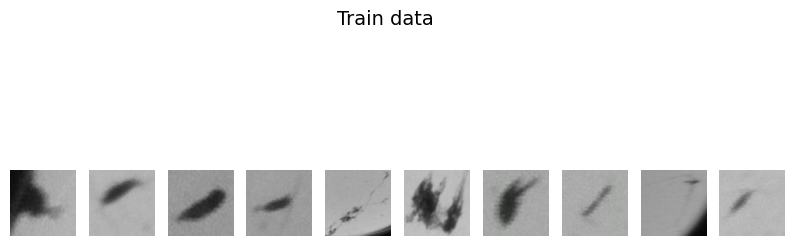

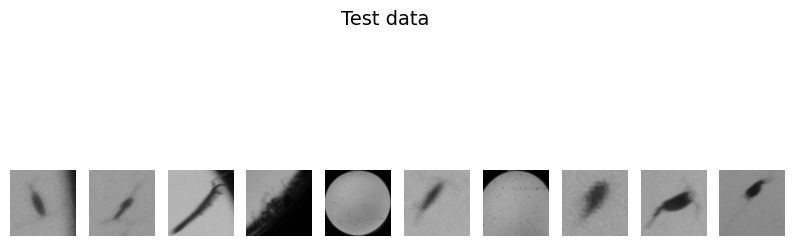

In [9]:
show_images(X_train,  title="Train data", plot_type="flat")
show_images(X_test, title="Test data", plot_type="flat")

# Building Autoencoder

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Code (latent vector)
        self.code = nn.MaxPool2d(kernel_size=2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        code = self.code(encoded)
        decoded = self.decoder(code)
        return decoded

In [86]:
X_train = X_train.to(device)
X_test = X_test.to(device)

train_dataset = torch.utils.data.TensorDataset(X_train, X_train)
test_dataset = torch.utils.data.TensorDataset(X_test, X_test)

# Define the batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the autoencoder
autoencoder = Autoencoder().to(device)

# Define the optimizer and loss func4tion
optimizer = optim.Adam(autoencoder.parameters())
loss_fn = nn.MSELoss()

# Define the number of epochs
epochs = 50

# Training Loop

In [87]:
for epoch in range(epochs):
    # Training phase
    autoencoder.train()
    train_loss = 0.0
    for batch_data, _ in train_loader:
        # Resize the target tensors to match the output size
        target = torch.nn.functional.interpolate(batch_data, size=(64, 64), mode='bilinear', align_corners=False)
        
        # Move data to CUDA device
        batch_data = batch_data.to(device)
        target = target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = autoencoder(batch_data)

        # Compute the loss
        loss = loss_fn(output, target)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation phase
    autoencoder.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_data, _ in test_loader:
            # Resize the target tensors to match the output size
            target = torch.nn.functional.interpolate(batch_data, size=(64, 64), mode='bilinear', align_corners=False)
            
            # Move data to CUDA device
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            # Forward pass
            output = autoencoder(batch_data)

            # Compute the loss
            loss = loss_fn(output, target)
            test_loss += loss.item()

        test_loss /= len(test_loader)

    # Print the training progress
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.8f} | Test Loss: {test_loss:.8f}")

Epoch 1/50 | Train Loss: 0.05269539 | Test Loss: 0.00968952
Epoch 2/50 | Train Loss: 0.00637376 | Test Loss: 0.00348797
Epoch 3/50 | Train Loss: 0.00262134 | Test Loss: 0.00229076


KeyboardInterrupt: 

In [ ]:
# autoencoder.eval()

# # Pass the input data through the encoder to get the latent vectors
# with torch.no_grad():
#     latent_vectors = autoencoder.encoder(X_train)

# # Save the latent vectors
# torch.save(latent_vectors, "Zooplankon_latent_AE.pt")

In [ ]:
autoencoder.eval()

# Pass the input data through the encoder to get the latent vectors
with torch.no_grad():
    latent_vectors = autoencoder.encoder(X_train)

# Reshape the latent vectors for visualization
latent_vector = latent_vectors.reshape(len(X_train), -1)

# Print the shapes
print("X_test.shape :", X_train.shape)
print("latent_vector.shape :", latent_vector.shape)

In [ ]:
autoencoder.eval()

# Pass the latent vectors through the decoder to reconstruct the images
with torch.no_grad():
    reconstructed_images = autoencoder.decoder(latent_vectors)

reconstructed_images = reconstructed_images.cpu()

# Clip the pixel values to the valid range of [0, 255]
reconstructed_images = torch.clamp(reconstructed_images, 0, 255)

# Convert the reconstructed images to numpy array
reconstructed_images = reconstructed_images.cpu().numpy()

# Show the original images, encoded representation, and reconstructed images
show_images(X_train.cpu(), title="original images", plot_type="flat")
show_images(latent_vector.cpu(), h=32, w=64, latent_vector=True, title="encoded representation", plot_type="flat")
show_images(reconstructed_images, title="reconstructed images", plot_type="flat")

# Clustering the Latent Space

In [ ]:
k = 67
random_state = np.random.randint(0, 500)
clusters = KMeans(k, random_state=random_state)
clusters.fit(latent_vector.cpu())
cluster_id = clusters.labels_

In [ ]:
print(X_train.shape)

In [ ]:
df = pd.DataFrame(X_train.cpu().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
df["clusterid"] = clusters.labels_
df

In [ ]:
clusters = dict()
for cid in df.clusterid.unique():
    clusters[cid] = df[df.clusterid == cid].drop("clusterid", axis="columns").to_numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_random_samples(X, n=12, h=400, w=400, latent_vector=False, title="", figsize=(16, 16), plot_type="grid"):
    # Reshape if needed
    if X.ndim == 2 and latent_vector:
        X = X.reshape(X.shape[0], 3, h, w)
    if X.ndim == 2:
        X = X.reshape(X.shape[0], 3, h, w)
    
    # Take random sample
    idxs = np.random.randint(len(X), size=n)
    
    # Create a list to store images from each cluster
    cluster_images = [[] for _ in range(n)]
    
    # Collect images from each cluster
    for i, idx in enumerate(idxs):
        cluster_images[i % n].append(X[idx])
    
    # Calculate optimal figsize for horizontal display
    image_height = cluster_images[0][0].shape[1]
    image_width = cluster_images[0][0].shape[2]
    figsize = (figsize[0], (figsize[0] / n) * (image_height / image_width))
    
    # Plot images horizontally for each cluster
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    for i, images in enumerate(cluster_images):
        combined_image = np.concatenate(images, axis=2)
        ax[i].imshow(combined_image.transpose(1, 2, 0))
        ax[i].axis('off')
        ax[i].set_aspect('auto')
    
    # Show plot
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


In [ ]:
for cid in sorted(clusters.keys()):
    show_random_samples(clusters[cid], h=128, w=128, n=12, title=f"cluster {cid}", plot_type="grid")

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have the `clusters` dictionary containing the cluster data

# Concatenate the clusters into a single array
concatenated_clusters = np.concatenate(list(clusters.values()))

# Create a DataFrame for the concatenated clusters
df_concatenated = pd.DataFrame(concatenated_clusters)

# Add a column for cluster labels
df_concatenated['clusterid'] = np.concatenate([np.full(len(cluster), cid) for cid, cluster in clusters.items()])

# Perform t-SNE on the concatenated data
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(df_concatenated.drop('clusterid', axis=1))

# Create a scatter plot of the t-SNE representation with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_representation[:, 0], y=tsne_representation[:, 1], hue=df_concatenated['clusterid'], palette='Set1', legend='full')
plt.title('t-SNE Plot of All Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
labels_df = pd.read_csv("All_csv_combined/orignal_annotations.csv")

In [ ]:
name_to_label = dict(zip(labels_df["2: Video or Image Identifier"], labels_df["10-11+: Repeated Species"]))

In [ ]:
pip install fuzzywuzzy

In [ ]:
# import pandas as pd
# from fuzzywuzzy import fuzz

# # Load the CSV file containing the image labels
# labels_df = pd.read_csv("All_csv_combined/orignal_annotations.csv")

# # Create a dictionary to map image names to labels
# name_to_label = dict(zip(labels_df["2: Video or Image Identifier"], labels_df["10-11+: Repeated Species"]))

# # Print the original labels for each cluster
# for cid in sorted(clusters.keys()):
#     cluster_images = clusters[cid]
#     cluster_labels = []

#     for i, image_name in enumerate(cluster_images[:10]):
#         # Find the nearest image name in the CSV file using fuzzy string matching
#         best_match = max(labels_df["2: Video or Image Identifier"], key=lambda x: fuzz.token_sort_ratio(x, image_name))
#         cluster_labels.append(name_to_label.get(best_match, "Unknown"))
    
#     print(f"Cluster {cid} - Labels: {cluster_labels}")


# Estimization-Maximization Clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Define the number of clusters and random state
k = 67
random_state = np.random.randint(0, 500)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=k, random_state=random_state)
gmm.fit(latent_vector.cpu())
cluster_id = gmm.predict(latent_vector.cpu())

# Create DataFrame with cluster labels
df = pd.DataFrame(X_train.cpu().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
df["clusterid"] = cluster_id

# Store clusters in a dictionary
clusters = dict()
for cid in df.clusterid.unique():
    clusters[cid] = df[df.clusterid == cid].drop("clusterid", axis="columns").to_numpy()

# Function to visualize random samples
import numpy as np
import matplotlib.pyplot as plt

def show_random_samples(X, n=12, h=400, w=400, latent_vector=False, title="", figsize=(16, 16), plot_type="grid"):
    # Reshape if needed
    if X.ndim == 2 and latent_vector:
        X = X.reshape(X.shape[0], 3, h, w)
    if X.ndim == 2:
        X = X.reshape(X.shape[0], 3, h, w)
    
    # Take random sample
    idxs = np.random.randint(len(X), size=n)
    
    # Create a list to store images from each cluster
    cluster_images = [[] for _ in range(n)]
    
    # Collect images from each cluster
    for i, idx in enumerate(idxs):
        cluster_images[i % n].append(X[idx])
    
    # Calculate optimal figsize for horizontal display
    image_height = cluster_images[0][0].shape[1]
    image_width = cluster_images[0][0].shape[2]
    figsize = (figsize[0], (figsize[0] / n) * (image_height / image_width))
    
    # Plot images horizontally for each cluster
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    for i, images in enumerate(cluster_images):
        combined_image = np.concatenate(images, axis=2)
        ax[i].imshow(combined_image.transpose(1, 2, 0))
        ax[i].axis('off')
        ax[i].set_aspect('auto')
    
    # Show plot
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Visualize clusters
for cid in sorted(clusters.keys()):
    show_random_samples(clusters[cid], h=128, w=128, n=8, title=f"cluster {cid}", plot_type="grid")


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have the `clusters` dictionary containing the cluster data

# Concatenate the clusters into a single array
concatenated_clusters = np.concatenate(list(clusters.values()))

# Create a DataFrame for the concatenated clusters
df_concatenated = pd.DataFrame(concatenated_clusters)

# Add a column for cluster labels
df_concatenated['clusterid'] = np.concatenate([np.full(len(cluster), cid) for cid, cluster in clusters.items()])

# Perform t-SNE on the concatenated data
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(df_concatenated.drop('clusterid', axis=1))

# Create a scatter plot of the t-SNE representation with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_representation[:, 0], y=tsne_representation[:, 1], hue=df_concatenated['clusterid'], palette='Set1', legend='full')
plt.title('t-SNE Plot of All Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
